In [1]:
import os
import json 
import subprocess
import importlib
import glob

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patheffects as pe

import xbitinfo as xb
import xarray as xr

/home/datacomp/miniconda3/envs/bitinfo/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning) 

---

In [3]:
!pwd

/home/datacomp/notebooks/high-resolution


In [4]:
path_to_data = '../data/netcdf/ecmwf_hs3g_20181101_cp.nc'  # change this
ds = xr.open_dataset(path_to_data)

In [5]:
ds = ds.sel({'longitude': ds.longitude[::],
                   'latitude': ds.latitude[:12000]
                  })

In [6]:
ds

<xarray.Dataset>
Dimensions:    (longitude: 24000, latitude: 12000, time: 1)
Coordinates:
  * longitude  (longitude) float32 0.0 0.015 0.03 0.045 ... 360.0 360.0 360.0
  * latitude   (latitude) float32 90.0 89.99 89.97 ... -89.96 -89.97 -89.99
  * time       (time) datetime64[ns] 2018-11-01T18:00:00
Data variables:
    cp         (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-06-23 10:20:32 GMT by grib_to_netcdf-2.30.2: grib_to_n...

In [7]:
# get information content per bit
info_per_bit = xb.get_bitinformation(ds, dim="latitude",
                                     # implementation="python"
                                    )

Processing var: cp for dim: latitude: 100%|███████████████████████| 1/1 [00:49<00:00, 49.13s/it]


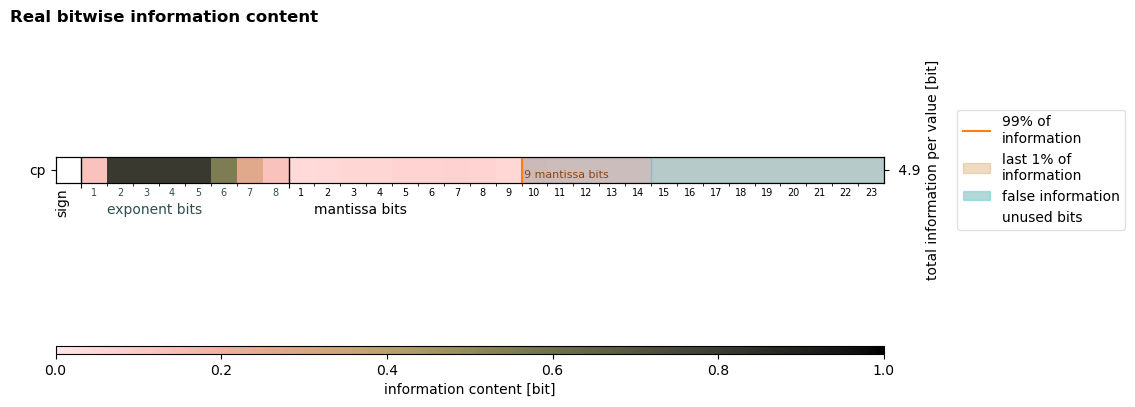

In [8]:
fig = xb.plot_bitinformation(info_per_bit)

---

In [9]:
at_least_zero = lambda x: [max(y, 0) for y in x]

chunk_long, chunk_lat = [800, 400] # for int division
vrbs = ['longitude', 'latitude']
var = 'latitude'

dss = []
dss_bitrounded = []
dss_kbits = []

long_c = int(ds.longitude.size / chunk_long)
lat_c = int(ds.latitude.size / chunk_lat)


for i in range(long_c):
    for j in range(lat_c):
        temp_ds = ds.isel(longitude=slice(i*chunk_long, (i+1)*chunk_long),
                          latitude=slice(j*chunk_lat, (j+1)*chunk_lat))
        dss.append(temp_ds)
        
        temp_info_pbit = xb.get_bitinformation(temp_ds, dim=var, implementation="python")
        
        temp_keepbits = xb.get_keepbits(temp_info_pbit, 0.99)
        var_kp = list(temp_keepbits.keys())[0]
        # cope with negative keepbits
        temp_keepbits[var_kp].data = at_least_zero(temp_keepbits[var_kp].data)
        dss_kbits.append(temp_keepbits)
        
        temp_ds_bitrounded = xb.xr_bitround(temp_ds, temp_keepbits)
        dss_bitrounded.append(temp_ds_bitrounded)

Processing var: cp for dim: latitude: 100%|███████████████████████| 1/1 [00:00<00:00,  3.60it/s]


---

In [10]:
variables = list(ds.keys())
variables

['cp']

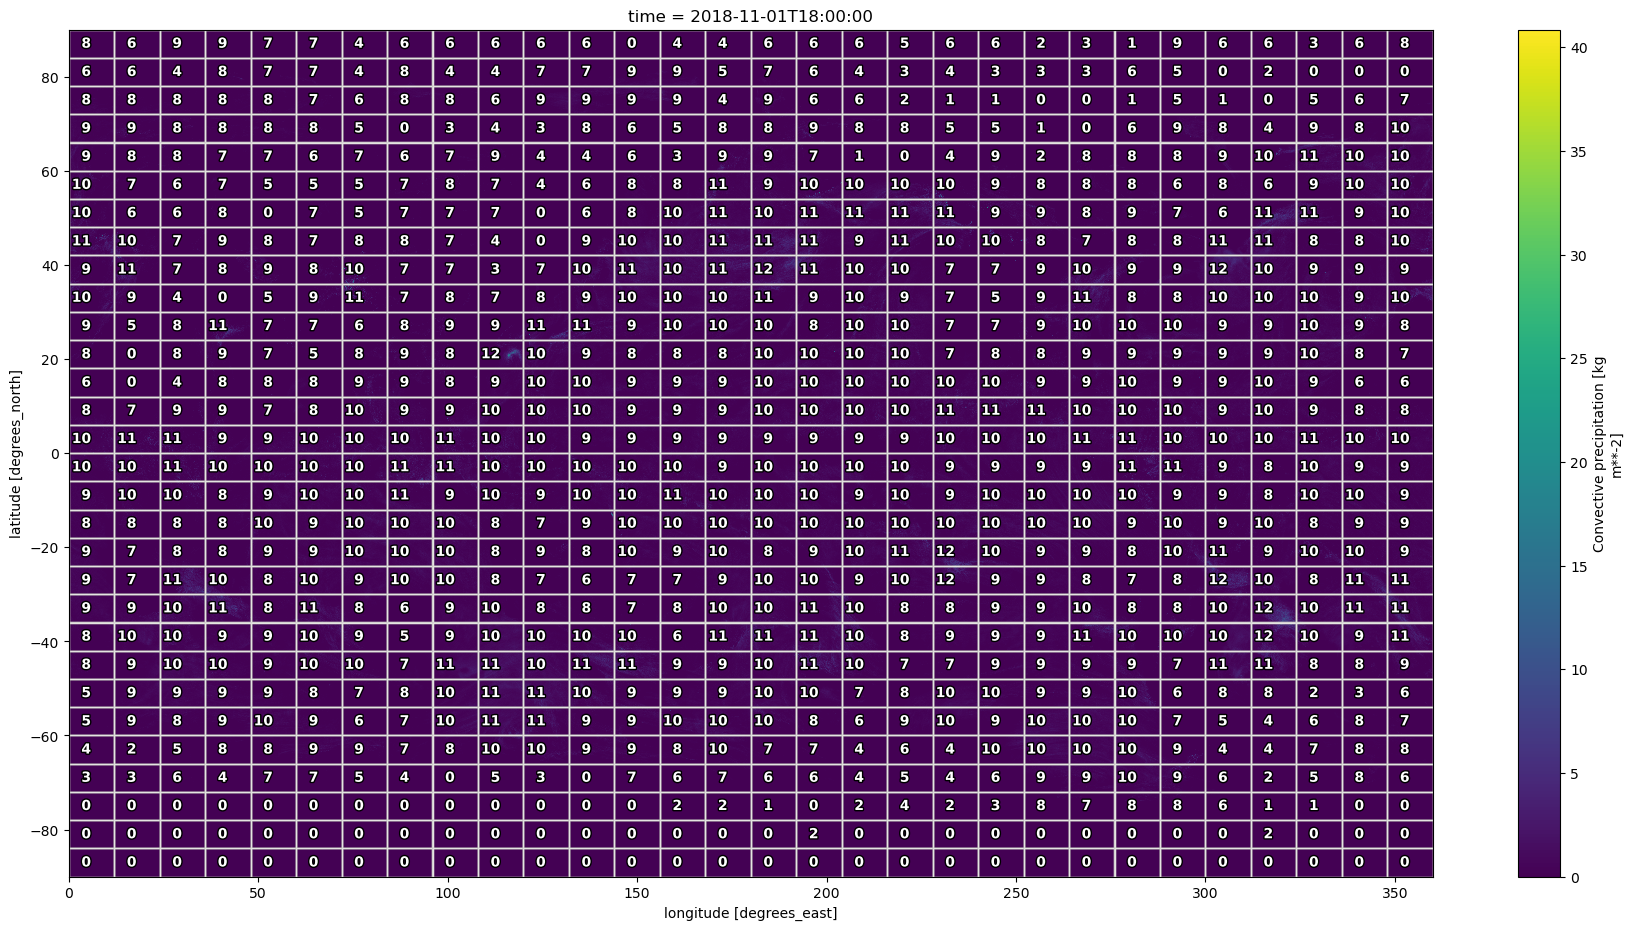

In [11]:
for v in variables:
    fig, ax = plt.subplots(figsize=(22, 11))
        
    ds[v].plot(ax=ax)

    for i in range(len(dss_bitrounded)):
        x = float(min(dss[i].longitude[0], dss[i].longitude[-1]))
        y = float(min(dss[i].latitude[0], dss[i].latitude[-1]))
        w = float(abs(dss[i].longitude[0] - dss[i].longitude[-1]))
        h = float(abs(dss[i].latitude[0] - dss[i].latitude[-1]))
        rect = mpl.patches.Rectangle((x, y), width = w, height = h,
                                    facecolor = "none", edgecolor = "#E5E4E2",
                                    path_effects=[pe.withStroke(linewidth=1, foreground="gray")],
                                    label='xxx')
        ax.add_patch(rect)
        rx, ry = rect.get_xy()
        cx = rx + rect.get_width()/2.0
        cy = ry + rect.get_height()/2.0
        ax.annotate(
            f"""
            {int(dss_kbits[i][v]):2}
            """,
            (cx, cy), color='w', weight='bold', fontsize=10, ha='right', va='center',
            path_effects=[pe.withStroke(linewidth=2, foreground='k')]
        )

    fig.show()

In [12]:
data = [[int(i) for i in list(dss_kbits[j].to_array().data)] for j in range(len(dss_kbits))]
variables = list(ds.keys())

df = pd.DataFrame(data=data,
                  columns=variables)
df.head()              

/tmp/ipykernel_10181/4235891130.py:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data = [[int(i) for i in list(dss_kbits[j].to_array().data)] for j in range(len(dss_kbits))]
/tmp/ipykernel_10181/4235891130.py:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data = [[int(i) for i in list(dss_kbits[j].to_array().data)] for j in range(len(dss_kbits))]
/tmp/ipykernel_10181/4235891130.py:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data = [[int(i) for i in list(d

,cp
0,8
1,6
2,8
3,9
4,9


In [13]:
df.describe()

,cp
count,900.000000
mean,7.418889
std,3.291388
min,0.000000
25%,6.000000
50%,9.000000
75%,10.000000
max,12.000000
